# Pittsburgh's 'Best' Neighborhood by team Small Ideas

## Why

When deciding which metrics to pick, we thought it made sense to determine factors that affect our daily lives. Being students who live off campus, we spend time nearly everyday commuting to and from campus relying on buses and bike lanes. Additionally, we both enjoy spending time in parks around the city. Therefore, our chosen metrics—number of bus stops, length of bike lanes, and amount of parks—reflect our personal experiences and preferences, aiming to quantify the elements that enhance our daily lives.

#### Public Transit Accessibility (Number of Bus Stops):

- Public transit accessibility is a vital factor for many residents when choosing a neighborhood.
- Number of bus stops indicates the extent of public transit coverage within the neighborhood.
- More bus stops imply better access to transportation, which enhances mobility and reduces reliance on private vehicles.

#### Active Transportation Infrastructure (Length of Bike Lanes):

- Length of bike lanes reflects the neighborhood's commitment to promoting active transportation.
- Bike lanes encourage cycling, which promotes physical activity, reduces traffic congestion, and decreases carbon emissions.
- Well-connected bike lanes enhance connectivity within the neighborhood and to neighboring areas, contributing to overall livability.

#### Quality of Outdoor Spaces (Amount of Parks):

- Parks and green spaces are essential for recreation, relaxation, and community engagement.
- The amount of parks within a neighborhood indicates its dedication to providing accessible outdoor amenities for residents.
- Parks offer numerous health and social benefits, including stress reduction, improved mental well-being, and opportunities for social interaction.

## Plan
Our plan is to use a dataset we found that contains data detailing the location and bounds of each neighborhood and a python script that verifies if a point's latitude and longitude fall inside of a given neighborhood. We will do this for every neighborhood. Using the count of each submetric (Parks, Protected Lanes, and Transit Stops) we will determine a score for each neighborhood and choose that neighborhood as our 'best' neighborhood. Using the counts for each metric for each neighborhood, we will normalize the counts into values which we will then we will composite into an overall score of 'bestness'.

##### Neighborhoods:
![Neighborhoods](image.png)

## Process

#### Determining if a point falls within a neighborhood:
To determine if a point falls within a neighborhood, we first create a list of shapely polygons containing location data for each neighborhood. We keep track of the names of each neighborhood by creating another list of names. Once we have a list of polygons we have a function that accepts a coordinate in the form of latitude and longitude. The function iterates through each neighborhood and uses shapely.polygon.contains() to determine if the point falls within the neighborhood polygon. If the point is within the neighborhood it returns the name of the neighborhood.

In [ ]:
from shapely.geometry import shape, Point

# Load GeoJSON data for neighborhoods
with open('neighborhoods.geojson') as f:
    geojson_data = json.load(f)

# Extract neighborhood polygons
polygons = []
hoods = []
for feature in geojson_data['features']:
    polygon = shape(feature['geometry'])
    polygons.append(polygon)
    hoods.append(feature['properties']['hood'])

# Define a function to check if a point is within any polygon
def is_point_within_polygon(lat, lon):
    point = Point(lon, lat)
    for i, polygon in enumerate(polygons):
        if polygon.contains(point):
            return hoods[i]
    return None

#### Generating a Count for each Neighborhood and Metric
After creating our is_point_within_polygon() method, we wrote code to create a count for each neighborhood and each metric. Data is loaded from the dataset CSV and added to a list containing points in the form of (latitude, longitude). We also create a dictionary to store the name and counts for each neighborhood. Once a list of points is created we iterate through the list of points and run the is_point_within_polygon() method on each, if the point is found to be in a neighborhood it takes the neighborhood name and either increments the count or initializes the neighborhood in the dictionary. We used this code for our bus stops and parks metric.

In [ ]:
# Read the CSV file containing latitude and longitude for parks
parks_data = []
with open('data\city-parks.csv', 'r') as file:
    next(file)  # Skip header
    for line in file:
        parts = line.strip().split(',')
        lat, lon = map(float, parts[-2:])
        parks_data.append((lat, lon))

# Create a dictionary to store parks count
parks_results = {"neighborhoods": []}

# Iterate through each park point
for lat, lon in parks_data:
    hood = is_point_within_polygon(lat, lon)
    if hood is not None:
        found = False
        for entry in parks_results["neighborhoods"]:
            if entry["name"] == hood:
                entry["parks"] += 1
                found = True
                break
        if not found:
            parks_results["neighborhoods"].append({"name": hood, "parks": 1})

#### Determining a Metric For Bike Lanes
Determining a metric for bike lanes was not as simple. The dataset we chose store bike lanes in geojson as pairs of points marking the beginning and end points of lines that create segments of a larger line, known as a MultiLineString in geojson. One way to use this data is to count how many of the beginning and end points fall within a neighborhood. After some thought we decided this information wouldnt be representative as lines with more curves would have more points thus scoring higher. Instead, we decided to create a metric for the length of bike lanes within a neighborhood. To do this, we created code that iterated through each bike lane feature in the dataset geojson. We then convert the feature into a shapely object and iterate through our neighborhoods checking if the bike lane intersects the neighborhood polygon. If it does intersect, generate the part that intersects as a new line then add its length to the corresponding neighborhoods bike lane length attribute.
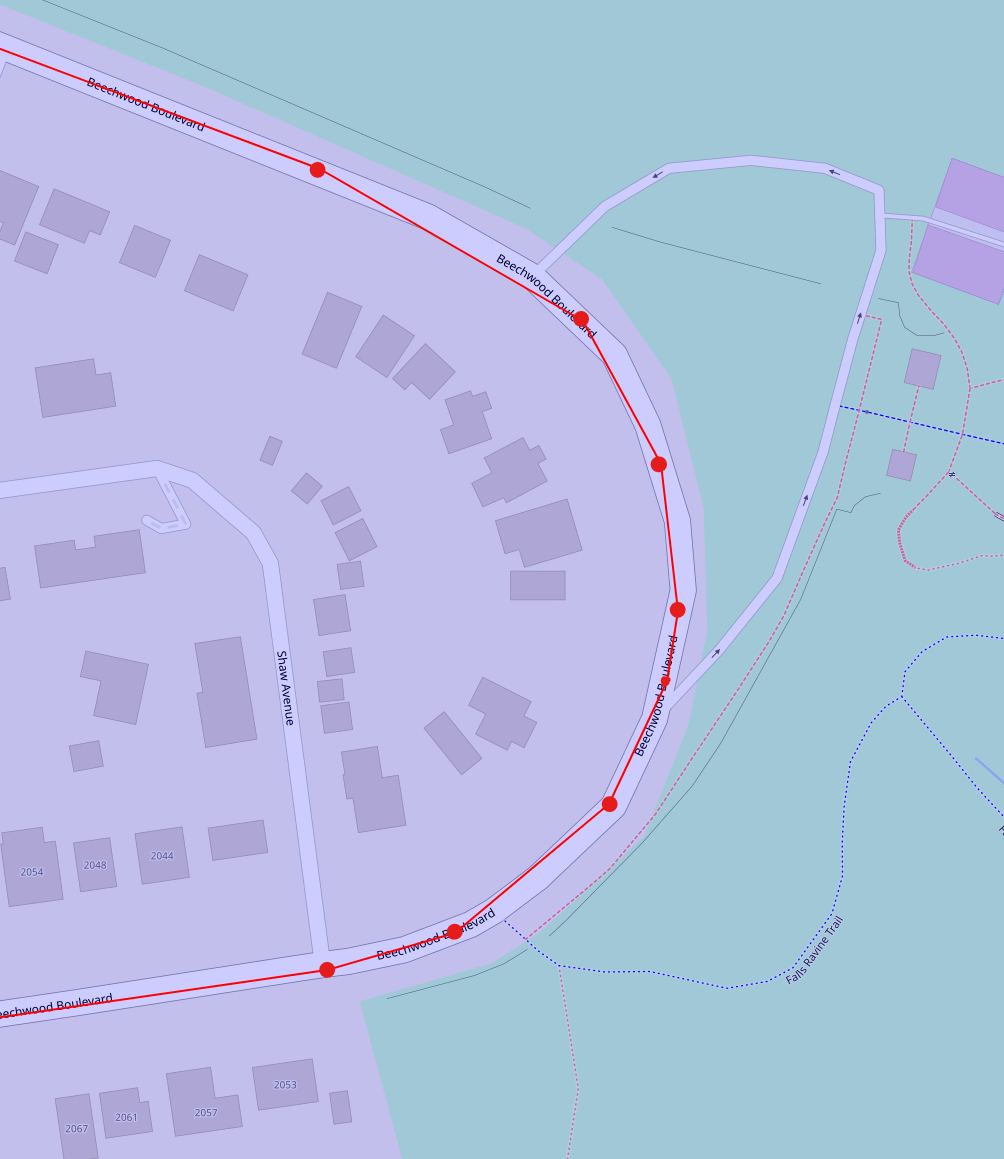

In [ ]:
# Load GeoJSON data for bikelanes
with open('data/2019-bike-lanes.geojson') as f:
    bikelanes_data = json.load(f)

# Initialize a dictionary to store lane lengths
bikelane_lengths = {hood_name: 0.0 for hood_name in hoods}

# Iterate over each bike lane feature
for feature in bikelanes_data['features']:
    bikelane_geometry = shape(feature['geometry'])
    # Iterate through each neighborhood
    for hood_name, polygon in zip(hoods, polygons):
        # Check if the bike lane intersects with the neighborhood polygon
        if bikelane_geometry.intersects(polygon):
            # Calculate the length of the intersection
            intersection = bikelane_geometry.intersection(polygon)
            bikelane_lengths[hood_name] += intersection.length

# Update merged_results with bike lane lengths
for entry in merged_results["neighborhoods"]:
    hood_name = entry["name"]
    entry["bikelane_length"] = bikelane_lengths[hood_name]

#### Scoring
After gathering the data for each metric, we wrote code to normalize the values. We then assigned weights for each attribute in order to adjust metrics to hold more importance. Using the weighted normalized metrics we added them up to create a composite score for each neighborhood.

In [ ]:
# Normalize the data
max_parks = max(neighborhood['parks'] for neighborhood in neighborhoods)
max_prt_stops = max(neighborhood['prt-stops'] for neighborhood in neighborhoods)
max_bikelane_length = max(neighborhood['bikelane_length'] for neighborhood in neighborhoods)



for neighborhood in neighborhoods:
    neighborhood['parks_normalized'] = neighborhood['parks'] / max_parks
    neighborhood['prt_stops_normalized'] = neighborhood['prt-stops'] / max_prt_stops
    neighborhood['bikelane_length_normalized'] = neighborhood['bikelane_length'] / max_bikelane_length

# Assign weights (you can adjust these according to your preference)
weights = {
    'parks': .3,
    'prt_stops': .4,
    'bikelane_length': 0.3
}

# Calculate composite score
for neighborhood in neighborhoods:
    neighborhood['composite_score'] = (
        weights['parks'] * neighborhood['parks_normalized'] +
        weights['prt_stops'] * neighborhood['prt_stops_normalized'] +
        weights['bikelane_length'] * neighborhood['bikelane_length_normalized']
    )

At this point we have organized and computed this data for each neighborhood:

In [ ]:
"name": "Beechview",
"parks": 8,
"prt-stops": 31,
"bikelane_length": 0.0,
"parks_normalized": 0.6666666666666666,
"prt_stops_normalized": 0.2980769230769231,
"bikelane_length_normalized": 0.0,
"composite_score": 0.9647435897435896

#### Final Result
The rest was simply finding the maximum composite score. Fianlly, we wrote this code to do so:

In [ ]:
import json

#Load JSON
with open('processed data\composite_scores.json', 'r') as file:
    neighborhoods = json.load(file)

# Find the best neighborhood
best_neighborhood = max(neighborhoods, key=lambda x: x['composite_score'])

print("Best neighborhood:", best_neighborhood['name'])
print("Composite score:", best_neighborhood['composite_score'])

: 